<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/supplements/mlp_cifar_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MLP for image classification using PyTorch

In this section, we follow Chap. 7 of the [Deep Learning With PyTorch](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf) book, and illustrate how to fit an MLP to a two-class version of CIFAR. (We modify the code from [here](https://github.com/deep-learning-with-pytorch/dlwpt-code/tree/master/p1ch7).)



In [ ]:
import sklearn
import scipy
import scipy.optimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import itertools
import time
from functools import partial

import os

import numpy as np
from scipy.special import logsumexp
np.set_printoptions(precision=3)




In [ ]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
print("torch version {}".format(torch.__version__))
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  print("current device {}".format(torch.cuda.current_device()))
else:
  print("Torch cannot find GPU")

def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#torch.backends.cudnn.benchmark = True

torch version 1.8.0+cu101
Tesla V100-SXM2-16GB
current device 0


## Get the CIFAR dataset

In [ ]:
from torchvision import datasets

folder = 'data'
cifar10 = datasets.CIFAR10(folder, train=True, download=True)
cifar10_val = datasets.CIFAR10(folder, train=False, download=True)


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
print(type(cifar10))
print(type(cifar10).__mro__) # module resolution order shows class hierarchy


<class 'torchvision.datasets.cifar.CIFAR10'>
(<class 'torchvision.datasets.cifar.CIFAR10'>, <class 'torchvision.datasets.vision.VisionDataset'>, <class 'torch.utils.data.dataset.Dataset'>, <class 'typing.Generic'>, <class 'object'>)


50000
<class 'PIL.Image.Image'>
<PIL.Image.Image image mode=RGB size=32x32 at 0x7F4ACCD47ED0>


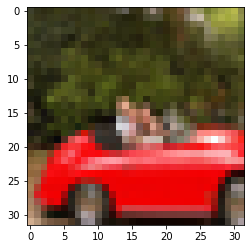

In [ ]:
print(len(cifar10))
img, label = cifar10[99]
print(type(img))
print(img)
plt.imshow(img)
plt.show()


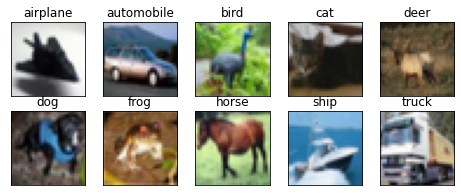

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

## Convert to tensors

In [ ]:
# Now we want to convert this to a tensor
from torchvision import transforms

to_tensor = transforms.ToTensor()

img, label = cifar10[99]
img_t = to_tensor(img)
print(type(img))
#print(img.shape)
print(type(img_t))
print(img_t.shape) # channels * height * width, here channels=3 (RGB)
print(img_t.min(), img_t.max()) # pixel values are rescaled to 0..1


<class 'PIL.Image.Image'>
<class 'torch.Tensor'>
torch.Size([3, 32, 32])
tensor(0.) tensor(1.)


In [ ]:
# transform the whole dataset to tensors
cifar10 = datasets.CIFAR10(folder, train=True, download=False,
                          transform=transforms.ToTensor())

<class 'torch.Tensor'>


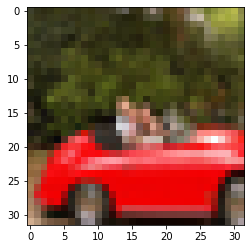

In [ ]:
img, label = cifar10[99]
print(type(img))
plt.imshow(img.permute(1, 2, 0)) # matplotlib expects H*W*C
plt.show()


## Standardize the inputs

We standardize the features by  computing the mean and std of each channel, averaging across all pixels and all images. This will help optimization.

In [ ]:
# we load the whole training set as a batch, of size 3*H*W*N

imgs = torch.stack([img for img, _ in cifar10], dim=3)
print(imgs.shape)


torch.Size([3, 32, 32, 50000])


In [ ]:
imgs_flat =  imgs.view(3, -1) # reshape by keeping first 3 channels, but flatten all others 
print(imgs_flat.shape)
mu = imgs_flat.mean(dim=1) # average over second dimension (H*W*N) to get one mean per channel
sigma = imgs_flat.std(dim=1)
print(mu)
print(sigma)

torch.Size([3, 51200000])
tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])


In [ ]:
cifar10 = datasets.CIFAR10(folder, train=True, download=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize(mu, sigma)
                          ]))

cifar10_val = datasets.CIFAR10(folder, train=False, download=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize(mu, sigma),
                          ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


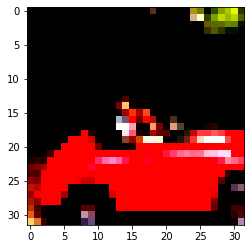

In [ ]:
# rescaled data is harder to visualize
img, _ = cifar10[99]

plt.imshow(img.permute(1, 2, 0))
plt.show()


## Create two-class version of dataset

We extract data which correspond to airplane or bird.
The result object is a list of pairs.
This "acts like" an object of type torch.utilts.data.dataset.Dataset, since it implements the len() and item index methods.

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

label_map = {0: 0, 2: 1} # 0(airplane)->0, 2(bird)->1
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [ ]:
print(len(cifar2))
print(len(cifar2_val))


10000
2000


## A shallow, fully connected model

In [ ]:
img, label = cifar10[0]
img = img.view(-1)
ninputs = len(img)
nhidden = 512
nclasses = 2

In [ ]:
torch.manual_seed(0)
model = nn.Sequential(nn.Linear(ninputs, nhidden),
            nn.Tanh(),
            nn.Linear(nhidden, nclasses),
            nn.LogSoftmax(dim=1))
print(model)



Sequential(
  (0): Linear(in_features=3072, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=2, bias=True)
  (3): LogSoftmax(dim=1)
)


We can name the layers so we can access their activations and/or parameters more easily.

In [ ]:
torch.manual_seed(0)
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
            ('hidden_linear', nn.Linear(ninputs, nhidden)),
            ('activation', nn.Tanh()),
            ('output_linear', nn.Linear(nhidden, nclasses)),
            ('softmax', nn.LogSoftmax(dim=1))
            ]))
print(model)

Sequential(
  (hidden_linear): Linear(in_features=3072, out_features=512, bias=True)
  (activation): Tanh()
  (output_linear): Linear(in_features=512, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


Let's test the model.

In [ ]:
img, label = cifar2[0]
img_batch = img.view(-1).unsqueeze(0)
print(img_batch.shape)
logprobs = model(img_batch)
print(logprobs.shape)
print(logprobs)
probs = torch.exp(logprobs) # elementwise
print(probs)
print(probs.sum(1))


torch.Size([1, 3072])
torch.Size([1, 2])
tensor([[-0.6193, -0.7729]], grad_fn=<LogSoftmaxBackward>)
tensor([[0.5383, 0.4617]], grad_fn=<ExpBackward>)
tensor([1.], grad_fn=<SumBackward1>)


 Negative log likelihood loss.

In [ ]:

loss_fn = nn.NLLLoss()
loss = loss_fn(logprobs, torch.tensor([label]))
print(loss)

tensor(0.7729, grad_fn=<NllLossBackward>)


Let's access the output of the logit layer directly, bypassing the final log softmax.
(We borrow a trick from [here](https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6)).

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.output_linear.register_forward_hook(get_activation('output_linear'))

logprobs = model(img_batch).detach().numpy()
logits = activation['output_linear']
logprobs2 = F.log_softmax(logits).detach().numpy()

print(logprobs)
print(logprobs2)
assert(np.allclose(logprobs, logprobs2))


[[-0.619 -0.773]]
[[-0.619 -0.773]]


We can also modify the model to return logits.

In [ ]:
torch.manual_seed(0)
model_logits = nn.Sequential(
            nn.Linear(ndims_input, nhidden),
            nn.Tanh(),
            nn.Linear(nhidden, nclasses))

logits2 = model_logits(img_batch)
print(logits)
print(logits2)
torch.testing.assert_allclose(logits, logits2)

tensor([[-0.1771, -0.3307]])
tensor([[-0.1771, -0.3307]], grad_fn=<AddmmBackward>)


In this case, we need to modify the loss to take in logits.

In [ ]:
logprobs = model(img_batch)
loss = nn.NLLLoss()(logprobs, torch.tensor([label]))

logits = model_logits(img_batch)
loss2 = nn.CrossEntropyLoss()(logits, torch.tensor([label]))

print(loss)
print(loss2)
torch.testing.assert_allclose(loss, loss2)

tensor(0.7729, grad_fn=<NllLossBackward>)
tensor(0.7729, grad_fn=<NllLossBackward>)


We can also use the functional API to specify the model. This avoids having to create stateless layers (i.e., layers with no adjustable parameters), such as the tanh or softmax layers.

In [ ]:

  
class MLP(nn.Module):
  def __init__(self, ninputs, nhidden, nclasses):
    super().__init__()
    self.fc1 = nn.Linear(ninputs, nhidden)
    self.fc2 = nn.Linear(nhidden, nclasses)

  def forward(self, x):
    out = F.tanh(self.fc1(x))
    out = self.fc2(out)
    return out # logits

torch.manual_seed(0)
model = MLP(ninputs, nhidden, nclasses)
logits = model(img_batch)
logits2 = model_logits(img_batch)
print(logits)
print(logits2)
torch.testing.assert_allclose(logits, logits2)

#print(list(model.named_parameters()))
nparams = [p.numel() for p in model.parameters() if p.requires_grad == True]
print(nparams)
# weights1, bias1, weights2, bias2
print([ninputs*nhidden, nhidden, nhidden*nclasses, nclasses])

tensor([[-0.1771, -0.3307]], grad_fn=<AddmmBackward>)
tensor([[-0.1771, -0.3307]], grad_fn=<AddmmBackward>)
[1572864, 512, 1024, 2]
[1572864, 512, 1024, 2]


## Evaluation pre-training

In [ ]:
def compute_accuracy(model, loader):
  correct = 0
  total = 0
  with torch.no_grad():
      for imgs, labels in loader:
          outputs = model(imgs.view(imgs.shape[0], -1))
          _, predicted = torch.max(outputs, dim=1)
          total += labels.shape[0]
          correct += int((predicted == labels).sum())
  return correct / total

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

torch.manual_seed(0)
model = MLP(ninputs, nhidden, nclasses)

acc_train = compute_accuracy(model, train_loader)
acc_val = compute_accuracy(model, val_loader)
print([acc_train, acc_val])

[0.4711, 0.4775]


## Training loop

In [ ]:
torch.manual_seed(0)
model = MLP(ninputs, nhidden, nclasses)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 20

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # At end of each epoch
    acc_val = compute_accuracy(model, val_loader)
    loss_train_batch = float(loss)
    print(f"Epoch {epoch}, Batch Loss {loss_train_batch}, Val acc {acc_val}")

Epoch 0, Batch Loss 0.7986931204795837, Val acc 0.758
Epoch 1, Batch Loss 0.7316719889640808, Val acc 0.781
Epoch 2, Batch Loss 0.6822570562362671, Val acc 0.7895
Epoch 3, Batch Loss 0.6403710842132568, Val acc 0.7935
Epoch 4, Batch Loss 0.603853702545166, Val acc 0.796
Epoch 5, Batch Loss 0.5708653926849365, Val acc 0.8035
Epoch 6, Batch Loss 0.5402626991271973, Val acc 0.8075
Epoch 7, Batch Loss 0.5115160942077637, Val acc 0.808
Epoch 8, Batch Loss 0.48429471254348755, Val acc 0.8115
Epoch 9, Batch Loss 0.45831188559532166, Val acc 0.8095
Epoch 10, Batch Loss 0.4333283007144928, Val acc 0.808
Epoch 11, Batch Loss 0.40905866026878357, Val acc 0.808
Epoch 12, Batch Loss 0.3851880431175232, Val acc 0.811
Epoch 13, Batch Loss 0.3614955246448517, Val acc 0.811
Epoch 14, Batch Loss 0.33788853883743286, Val acc 0.8105
Epoch 15, Batch Loss 0.31435394287109375, Val acc 0.8115
Epoch 16, Batch Loss 0.29094964265823364, Val acc 0.813
Epoch 17, Batch Loss 0.267885684967041, Val acc 0.812
Epoch 18